In [1]:
from importlib import reload
import BacktestEngine.backtest as backtest
import BacktestEngine.order_book as order_book
import scipy.odr as odr

In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import yfinance as yf
import pickle
import os
import math
from ReferentialData.polygonData import PolygonAPI
from DataAnalysis import DataExtensions
from Filtering.KalmanFilter import KalmanFilter

In [3]:
## End Date
end_dt = "2025-02-25"
## Start date
start_dt = "2020-02-28"
# Loading "pairs trade" buckets
DIR = r'C:\Users\raymo\OneDrive\Desktop\Ray Stuff\_Cache'
COR_DIR = r'\Users\raymo\OneDrive\Desktop\Playground\Financial-Modelling-Playground\Quant_Trading\Clustering'
with open(os.path.join(COR_DIR, "correlation_buckets_no_shorts.pkl"), "rb") as file:
    BUCKETS = pickle.load(file)

In [4]:
# Concatenating dictionary value lists
UNIVERSE=[]
for i in list(BUCKETS.values()):
    UNIVERSE.extend(i)

In [5]:
colnames = ["Close", "Volume"]
DataLoader = PolygonAPI()
MID_LOADED = False
HIGH_LOADED = False
if not MID_LOADED:
    mid_df = {}
if not HIGH_LOADED:
    high_df = {}
### loading in low frequency data
if len(mid_df) == 0:
    mid_df = DataLoader.getPrices(UNIVERSE, timespan= "day", from_ = start_dt, 
                                    to_=end_dt,
                                  logDir=os.path.join(DIR,"Beta_Callibration"), _parallel=True)
    MID_LOADED = True

### loading in high frequency data
if len(high_df) == 0:
    high_df = DataLoader.getPrices(UNIVERSE,from_ = start_dt, 
                                    to_=end_dt, timespan="minute", logDir=DIR, _parallel=True, override=False)
    HIGH_LOADED = True


In [7]:
high_df[0]

{'AOA':            open     high      low    close  volume     vwap      timestamp  \
 0       52.9900  53.0783  52.8700  53.0783   15919  52.9881  1582900200000   
 1       53.1195  53.1195  53.1195  53.1195     154  53.1252  1582900260000   
 2       53.2265  53.3600  53.2265  53.3600    3474  53.2317  1582900320000   
 3       53.1800  53.1982  53.1301  53.1301    3065  53.1829  1582900380000   
 4       53.2325  53.2325  53.2325  53.2325     116  53.2428  1582900440000   
 ...         ...      ...      ...      ...     ...      ...            ...   
 124972  78.8800  78.8800  78.8800  78.8800     180  78.8688  1740516780000   
 124973  78.8550  78.8550  78.8550  78.8550     223  78.8548  1740516960000   
 124974  78.9000  78.9000  78.9000  78.9000     279  78.8998  1740517020000   
 124975  78.8850  78.9100  78.8850  78.9100     328  78.9002  1740517080000   
 124976  78.8600  78.9200  78.8600  78.9000    2047  78.9004  1740517140000   
 
         transactions   otc  
 0           

## Analysis of first correlation bucket

In [8]:
BUCKETS

{'AOA': ['AOA', 'SPXS', 'SPXU', 'SH', 'SDS'],
 'AIQ': ['AIQ', 'SQQQ', 'QID', 'PSQ'],
 'AGQ': ['AGQ', 'ZSL'],
 'AGG': ['AGG', 'TTT', 'TYO', 'TMV', 'TBT', 'TBX', 'PST'],
 'ACWX': ['ACWX', 'EPV', 'EFZ', 'EFU'],
 'ACWI': ['ACWI', 'SPXU', 'SPXS', 'SH', 'SDS'],
 'AAXJ': ['AAXJ', 'EUM', 'EEV'],
 'ZSL': ['ZSL', 'SLV', 'SIVR', 'GLTR'],
 'ZROZ': ['ZROZ', 'TMV', 'TTT', 'TBT'],
 'XBI': ['XBI', 'LABD'],
 'YCL': ['YCL', 'YCS'],
 'YINN': ['YINN', 'YANG', 'YXI', 'FXP'],
 'YCS': ['YCS', 'FXY'],
 'YXI': ['YXI', 'XPP', 'KWEB', 'GXC', 'FXI', 'CWEB', 'BKF'],
 'YANG': ['YANG', 'XPP', 'KWEB', 'GXC', 'FXI', 'CWEB', 'BKF'],
 'XT': ['XT', 'HIBS'],
 'XTR': ['XTR', 'SQQQ', 'SPXS', 'SPXU', 'SH', 'SDS', 'QID', 'PSQ'],
 'XSOE': ['XSOE', 'EUM', 'EEV'],
 'XSVM': ['XSVM', 'TWM', 'TZA', 'SRTY', 'SMDD', 'SDD', 'RWM'],
 'XSMO': ['XSMO', 'TZA', 'TWM', 'SRTY', 'SMDD', 'SDD', 'RWM'],
 'XPP': ['XPP', 'FXP'],
 'XNTK': ['XNTK', 'SQQQ', 'SOXS', 'QID', 'PSQ'],
 'XMLV': ['XMLV', 'SMDD'],
 'XMMO': ['XMMO', 'SMDD'],
 'XLG': ['XLG', 

In [9]:
# bucket_mask = lambda price_data: price_data[0] in BUCKETS[list(BUCKETS.keys())[1]]
bucket_mask = lambda price_data: price_data[0] in BUCKETS['VIXY']
hf_bucket = dict(filter(bucket_mask, high_df[0].items()))
mf_bucket = dict(filter(bucket_mask, mid_df[0].items()))

### Need to find weighting for positions in portfolio

In [10]:
beta = pd.read_csv(r'C:\Users\raymo\OneDrive\Desktop\Ray Stuff\_Cache\Beta_Callibration\^FTW5000_beta.csv')
beta = beta.loc[:, ~beta.columns.str.contains('^Unnamed')]
beta['Beta'] = [float(x.split(",")[0][1:]) for x in beta['Beta']]
beta = beta[beta.apply(bucket_mask, axis=1)]
beta = beta.set_index("Ticker")
beta = beta.to_dict()['Beta']

import yfinance as yf

bm_ticker = "^FTW5000"
## extract benchmark data 
yf_res = yf.Ticker(bm_ticker)
# get historical market data
# hist = mid_df[0]['ACWI']
hist = yf_res.history(interval="1D", period='2y').reset_index().rename(columns={'Close':bm_ticker,
                'Date':'timestamp'}).set_index('timestamp')
hist = hist.tz_localize(None)
bm_data = hist[[bm_ticker]]
bm_data

### save this since yahoo finance is really unstable...
bm_data.to_csv(r'C:\Users\raymo\OneDrive\Desktop\Playground\Financial-Modelling-Playground\Quant_Trading\BetaModels\FTW5000.csv')



C:\Users\raymo\AppData\Local\Temp\ipykernel_47712\1586568570.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  bucket_mask = lambda price_data: price_data[0] in BUCKETS['VIXY']


In [11]:
corr = pd.read_csv(r'C:\Users\raymo\OneDrive\Desktop\Ray Stuff\_Cache\Beta_Callibration\pairwise_corr.csv')
corr = corr.loc[:, ~corr.columns.str.contains('^Unnamed')]
bucket_corr_mask = lambda price_data: len(set(price_data[0].split(',')).intersection(set(BUCKETS[list(BUCKETS.keys())[0]])))==2
corr = corr[corr.apply(bucket_corr_mask, axis=1)]
corr = corr.sort_values(by="Cross Correlation")
corr

C:\Users\raymo\AppData\Local\Temp\ipykernel_47712\4063414317.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  bucket_corr_mask = lambda price_data: len(set(price_data[0].split(',')).intersection(set(BUCKETS[list(BUCKETS.keys())[0]])))==2


,Ticker Pair,Cross Correlation
7134,"AOA,SDS",-0.950992
7083,"AOA,SPXU",-0.948960
7125,"AOA,SH",-0.948941
7089,"AOA,SPXS",-0.948182
129160,"SPXS,SH",0.993566
128571,"SPXU,SH",0.994723
152083,"SH,SDS",0.997474
129169,"SPXS,SDS",0.997839
128540,"SPXU,SPXS",0.998401
128578,"SPXU,SDS",0.998524


In [12]:
hf_df = pd.DataFrame()
for ticker in hf_bucket:
    if len(hf_df) == 0:
        temp = hf_bucket[ticker].rename(columns={'close':ticker})[['timestamp',ticker]]
        temp['timestamp'] = pd.to_datetime(temp['timestamp'], unit='ms')
        hf_df = temp.set_index('timestamp')
    else:
        temp = hf_bucket[ticker].rename(columns={'close':ticker})[['timestamp',ticker]]
        temp['timestamp'] = pd.to_datetime(temp['timestamp'], unit='ms')
        hf_df = hf_df.join(temp.set_index('timestamp'),
                       how = 'left')
hf_df = hf_df.fillna(method='ffill')
hf_df = hf_df.dropna() ## removes dates where not all components are present
hf_df

C:\Users\raymo\AppData\Local\Temp\ipykernel_47712\2129899211.py:12: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  hf_df = hf_df.fillna(method='ffill')


,SVXY,SVIX,VIXY
timestamp,,,
2022-03-30 13:32:00,56.14,14.8800,15.7670
2022-03-30 13:33:00,56.15,14.8900,15.7500
2022-03-30 13:34:00,56.15,14.8900,15.7501
2022-03-30 13:35:00,56.22,14.8900,15.7200
2022-03-30 13:36:00,56.17,14.9000,15.7500
...,...,...,...
2025-02-25 23:55:00,50.30,24.9000,43.8200
2025-02-26 00:01:00,50.30,24.9000,43.8200
2025-02-26 00:17:00,50.37,24.9000,43.8200


In [13]:
min(hf_df.index)

Timestamp('2022-03-30 13:32:00')

In [14]:
mf_bucket['SVXY']

,open,high,low,close,volume,vwap,timestamp,transactions,otc
0,33.750,33.900,32.6500,33.225,7778068.0,33.1842,1582174800000,33294,NaN
1,32.715,32.855,31.7400,32.190,8503196.0,32.2007,1582261200000,34567,NaN
2,29.730,30.615,29.0950,29.135,11459590.0,29.8246,1582520400000,41449,NaN
3,29.790,29.880,27.4200,27.815,13483032.0,28.6994,1582606800000,54238,NaN
4,28.320,28.805,27.6500,28.195,12609526.0,28.2848,1582693200000,52757,NaN
...,...,...,...,...,...,...,...,...,...
1256,51.870,52.340,51.8000,52.320,696987.0,52.0847,1739941200000,6848,NaN
1257,52.300,52.500,51.7100,52.240,1364540.0,52.0809,1740027600000,14494,NaN
1258,52.250,52.250,50.1600,50.380,2421597.0,50.8465,1740114000000,23421,NaN
1259,50.790,51.130,49.6400,50.200,1538080.0,50.6017,1740373200000,14019,NaN


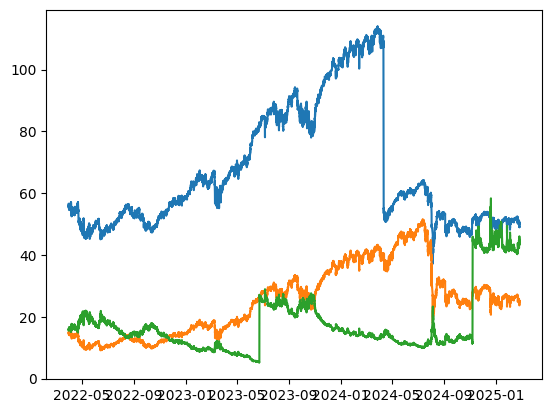

In [15]:
plt.plot(hf_df)

In [16]:
import datetime
from importlib import reload
import OptimizationEngine.mipEngine
reload(OptimizationEngine.mipEngine)

daily_dt = 10e3*60*60*24
min_dt = 10e3*60
dt_ratio = daily_dt / min_dt 

import time
def datetime_to_ms_epoch(dt):
    microseconds = time.mktime(dt.timetuple()) * 1000000 + dt.microsecond
    return int(round(microseconds / float(1000)))

def get_unixtime(dt64):
    return dt64.astype('datetime64[s]').astype('int')

def shift(xs, n):
    if n >= 0:
        return np.concatenate((np.full(n, np.nan), xs[:-n]))
    else:
        return np.concatenate((xs[-n:], np.full(-n, np.nan)))
    
def getTimeDiffs(dt_list: np.array):
    ## case to ms unix tyime
    if type(dt_list[0]) == np.datetime64:
        dt_list = get_unixtime(dt_list)
    shifted_dt = np.roll(dt_list, 1)
    res = dt_list - shifted_dt
    res[0] = 0 ## as this makes no sense
    return res

logReturnTransform = lambda df : np.log(df.loc[:,~df.columns.str.contains('timestamp')]) - np.log(df.loc[:,~df.columns.str.contains('timestamp')].shift(1))
def logRetDtDailyTransform(df):
    return logReturnTransform(df.loc[:,~df.columns.str.contains('timestamp')]).apply(
        lambda col: np.asarray(col) / getTimeDiffs(np.asarray(df.index.values)) *math.sqrt(dt_ratio))

# print('Beta Adjustment on Mid-Frequency is: {0}.'.format(mf_betaAdj))

mf_summary = {}
for data in mf_bucket:
    mu = logReturnTransform(mf_bucket[data].drop('otc',axis=1))['close'].mean()
    std = logReturnTransform(mf_bucket[data].drop('otc',axis=1))['close'].std()
    mu_hf = logRetDtDailyTransform(hf_bucket[data].drop('otc',axis=1))['close'].mean()
    std_hf = logRetDtDailyTransform(hf_bucket[data].drop('otc',axis=1))['close'].std()
    mf_summary[data] = {"Mu": mu, "Sigma":std, "Beta":beta[data],
                        "Mu_Min": mu_hf, "Sigma_Min": std_hf}
mf_summary = pd.DataFrame(mf_summary)

mf_summary

,SVXY,SVIX,VIXY
Mu,0.000326,0.000704,-0.002411
Sigma,0.025451,0.042613,0.047375
Beta,-0.000241,-0.000147,0.000504
Mu_Min,-0.000002,0.000069,0.000057
Sigma_Min,0.059076,0.087187,0.152957


In [17]:
hf_bucket['VIXY']

,open,high,low,close,volume,vwap,timestamp,transactions,otc
0,17.90,17.90,17.86,17.86,10860.0,17.8630,1583139600000,3,NaN
1,17.83,17.85,17.83,17.85,1720.0,17.8323,1583139660000,4,NaN
2,17.58,17.58,17.58,17.58,235.0,17.5800,1583140020000,2,NaN
3,17.68,17.68,17.60,17.60,400.0,17.6600,1583140200000,2,NaN
4,17.74,17.80,17.74,17.80,1200.0,17.7900,1583140380000,2,NaN
...,...,...,...,...,...,...,...,...,...
596789,43.76,43.76,43.76,43.76,100.0,43.7600,1740527640000,1,None
596790,43.54,43.54,43.54,43.54,1006.0,43.5401,1740528600000,2,None
596791,43.62,43.62,43.62,43.62,100.0,43.6200,1740530580000,1,None
596792,43.62,43.62,43.62,43.62,404.0,43.6204,1740531060000,2,None


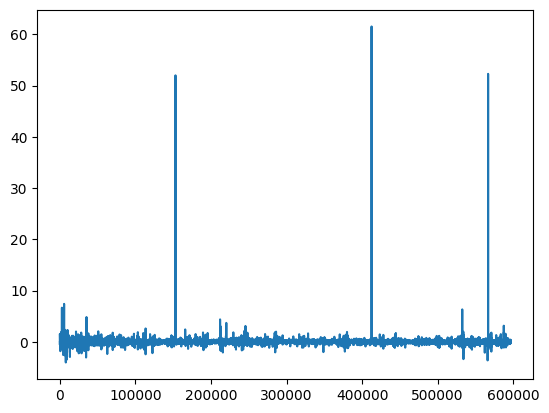

In [18]:
plt.plot(logRetDtDailyTransform(hf_bucket[data].drop('otc',axis=1))['close'])

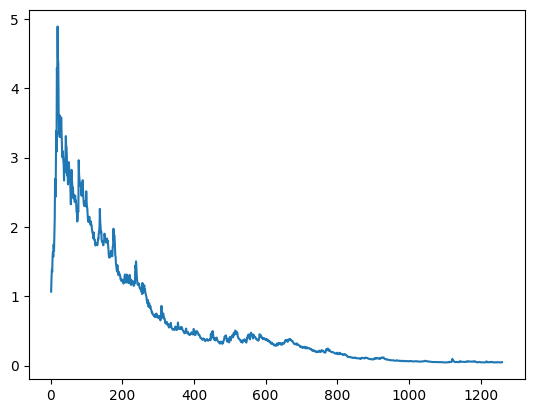

In [19]:
original = np.exp(logReturnTransform(mf_bucket['VIXY'].drop('otc',axis=1))['close'])
plt.plot(original.cumprod())
# plt.plot(mf_bucket['PSQ'].index, mf_bucket['PSQ']['PSQ'])
# mf_bucket['PSQ']

## Running Ordinary Linear Regression for Weighting

In [20]:

hf_df.to_csv(r'C:\Users\raymo\OneDrive\Desktop\test.csv')

In [21]:
import pandas as pd
from numpy import arange
from sklearn.linear_model import Ridge
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import ElasticNetCV
from sklearn.model_selection import RepeatedKFold#define cross-validation method to evaluate model

def RidgeRegression(X,y):
    cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)

    #define model
    model = RidgeCV(alphas=arange(0, 1, 0.01), 
                    cv=cv, 
                    scoring='neg_mean_absolute_error',
                    fit_intercept=False)

    #fit model
    model.fit(X, y)

    #display lambda that produced the lowest test MSE
    print(model.coef_)

    return model


def ElasticNet(X,y, l1=0.5):
    cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
    #define model
    model = ElasticNetCV(alphas=arange(0, 1, 0.01), 
                    cv=cv,
                    fit_intercept=False,
                    positive=True,
                    l1_ratio=l1)

    #fit model
    model.fit(X, y)

    #display lambda that produced the lowest test MSE
    print(model.coef_)

    return model

In [22]:
def tls(X, y):
    """
    Performs Total Least Squares regression.

    Args:
        X (numpy.ndarray): Design matrix (n_samples, n_features)
        y (numpy.ndarray): Target vector (n_samples,)

    Returns:
        numpy.ndarray: Estimated coefficients (n_features,)
    """

    # Construct augmented matrix
    A = np.hstack((X, y.reshape(-1, 1)))

    # Perform SVD
    U, S, V = np.linalg.svd(A)

    # Extract coefficients
    Vxy = V[-1, :-1]
    Vyy = V[-1, -1]

    return -Vxy / Vyy

In [23]:
bm_data

,^FTW5000
timestamp,
2023-02-28,39704.378906
2023-03-01,39537.910156
2023-03-02,39812.238281
2023-03-03,40450.949219
2023-03-06,40399.859375
...,...
2025-02-21,60137.691406
2025-02-24,59821.519531
2025-02-25,59519.980469


In [24]:
# Define a function (quadratic in our case)
# to fit the data with.
# odr initially assumes a linear function
def f(B, x):
    return B[0] + np.dot(B[1:], x)  # B[0] is the intercept, B[1:] are the slopes

### log returns of high frequency data frame

# neutralizeBeta = lambda dcol: dcol[ticker] - mf_summary[ticker] for ticker in df)
hf_log = logReturnTransform(hf_df)
hf_log = pd.merge_asof(hf_log, logReturnTransform(bm_data), on = 'timestamp').dropna().set_index('timestamp')
components = list(hf_log.columns.values)
components.remove(bm_ticker)
### remove beta from FTW5000
hf_log[components] = hf_log[components].apply(lambda dcol: dcol - mf_summary.loc['Beta', dcol.name] 
                                                    *hf_log[bm_ticker] , axis = 0)
hf_log.drop(bm_ticker, axis=1, inplace=True) ## remove benchmark data
reference_ticker = 'VIXY' #hf_df.columns[0]
x_temp = hf_log.loc[:, ~hf_log.columns.str.contains(reference_ticker)]
x_temp = -1*x_temp.iloc[1:]


# x1=  np.array(x_temp['SPXS'])
# x2= np.array(x_temp['SPXU'])
# x3 = np.array(x_temp['SH'])
# x4=np.array(x_temp['SDS'])
# x = np.column_stack((x1,x2,x3,x4))
x = np.array(x_temp)
y = np.array(hf_log[reference_ticker].iloc[1:])

#  model fitting.
odr_model = odr.Model(f)
 
# Create a Data object using sample data created.
data = odr.Data(x, y)
 
# # Set ODR with the model and data.
# ordinal_distance_reg = odr.ODR(data, odr_model,
#                                beta0=[0] + [1]*x.shape[1])
 
# # Run the regression.
# out = ordinal_distance_reg.run()
 
# # print the results
# out.pprint()

# ElasticNet(x,y, 0)
coeffs_ = RidgeRegression(x,y).coef_

# # Plot the data and the fit
# plt.scatter(x, y)
# plt.plot(x, out.beta[0] * x + out.beta[1], color='red')
# plt.xlabel('x')
# plt.ylabel('y')
# plt.title('Orthogonal Linear Regression')
# plt.show()

[0.2289063  0.54336204]


In [25]:
hf_df

,SVXY,SVIX,VIXY
timestamp,,,
2022-03-30 13:32:00,56.14,14.8800,15.7670
2022-03-30 13:33:00,56.15,14.8900,15.7500
2022-03-30 13:34:00,56.15,14.8900,15.7501
2022-03-30 13:35:00,56.22,14.8900,15.7200
2022-03-30 13:36:00,56.17,14.9000,15.7500
...,...,...,...
2025-02-25 23:55:00,50.30,24.9000,43.8200
2025-02-26 00:01:00,50.30,24.9000,43.8200
2025-02-26 00:17:00,50.37,24.9000,43.8200


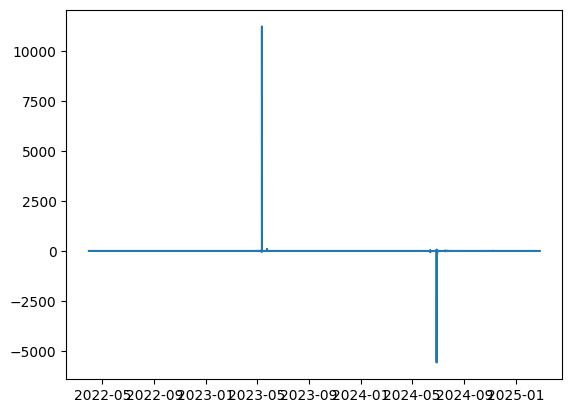

In [26]:
def hurst(ts):
    """Calculates the Hurst Exponent of the time series vector ts"""

    # Create the range of lag values
    lags = range(2, 100)

    # Calculate the array of the variances of the lagged differences
    tau = [np.sqrt(np.std(np.subtract(ts[lag:], ts[:-lag]))) for lag in lags]

    # Use a linear fit to estimate the Hurst Exponent
    poly = np.polyfit(np.log(lags), np.log(tau), 1)

    # Return the Hurst exponent from the polyfit output
    return poly[0] * 2.0

reference_ticker = "VIXY"
elementExp = lambda row, coeffs: np.power(np.array(row), coeffs_)
positive_legs = hf_df.loc[:, ~hf_df.columns.str.contains(reference_ticker)]
signal = positive_legs.apply(lambda dr:elementExp(dr, coeffs_).sum(), axis = 1)
signal = signal.add(-1*hf_df[reference_ticker])
raw = pd.DataFrame(positive_legs.apply(lambda dr:elementExp(dr, coeffs_).sum(), axis = 1)).join(hf_df[reference_ticker])
# print('Hurst: ', hurst(np.array(signal.resample('1D').agg('last').dropna())))
# plt.hist(signal.pct_change(),bins=100)
plt.plot(signal.pct_change())
# plt.scatter(logReturnTransform(positive_legs.apply(lambda dr:elementExp(dr, coeffs_).sum(), axis = 1)),
#             logReturnTransform(hf_df[reference_ticker]))

In [27]:
reload(DataExtensions)
outlier_idxs = DataExtensions.zscoreOutliers(signal.pct_change(), params={'std':6})
## these are looking for stock splits 
win1 = outlier_idxs[0]
hf_df[win1[0] - pd.Timedelta(days=2):win1[1]+ pd.Timedelta(days=2)]

,SVXY,SVIX,VIXY
timestamp,,,
2023-05-10 16:31:00,68.6300,18.7699,7.68
2023-05-10 16:32:00,68.6300,18.7600,7.69
2023-05-10 16:33:00,68.6123,18.7600,7.69
2023-05-10 16:34:00,68.6100,18.7500,7.69
2023-05-10 16:35:00,68.5600,18.7200,7.70
...,...,...,...
2023-05-12 20:01:00,69.2900,19.1200,7.54
2023-05-12 20:10:00,69.1700,19.0700,7.54
2023-05-12 20:11:00,69.1900,19.0700,7.54


In [28]:
# ### find new beta of signal to benchmark
# from BetaModels.BetaCovFactory import BetaCovFactory
# daily_signal = pd.DataFrame(signal.resample('1D').last().dropna(),
#                             columns=['DailySignal'])
# print(daily_signal)
# bm_ticker = "^FTW5000"

# ## extract benchmark data 
# yf_res = yf.Ticker(bm_ticker)
# info = yf_res.info
# # get historical market data
# hist = yf_res.history(interval="1D", period='5y').rename(columns={'Close':bm_ticker})
# hist = hist.tz_localize(None)
# #hist.index = hist.index.normalize()
# bm_data = hist[[bm_ticker]].rename(columns={'Date':'timestamp'})
# bmFactory = BetaCovFactory(logReturnTransform(bm_data)[1:])
# signalBeta = bmFactory.calculateBeta(logReturnTransform(daily_signal)[1:])[0]
# signalBeta

Signal = pd.DataFrame(signal, columns=['Signal'])
# Signal['timestamp'] = [datetime_to_ms_epoch(ts) for ts in Signal['timestamp']]
Signal

,Signal
timestamp,
2022-03-30 13:32:00,-8.916101
2022-03-30 13:33:00,-8.897415
2022-03-30 13:34:00,-8.897515
2022-03-30 13:35:00,-8.866698
2022-03-30 13:36:00,-8.895627
...,...
2025-02-25 23:55:00,-35.631687
2025-02-26 00:01:00,-35.631687
2025-02-26 00:17:00,-35.630907


In [29]:
positive_legs

,SVXY,SVIX
timestamp,,
2022-03-30 13:32:00,56.14,14.8800
2022-03-30 13:33:00,56.15,14.8900
2022-03-30 13:34:00,56.15,14.8900
2022-03-30 13:35:00,56.22,14.8900
2022-03-30 13:36:00,56.17,14.9000
...,...,...
2025-02-25 23:55:00,50.30,24.9000
2025-02-26 00:01:00,50.30,24.9000
2025-02-26 00:17:00,50.37,24.9000


In [30]:
reference_ticker

'VIXY'

c:\Users\raymo\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\internals\blocks.py:393: RuntimeWarning: invalid value encountered in log
  result = func(self.values, **kwargs)


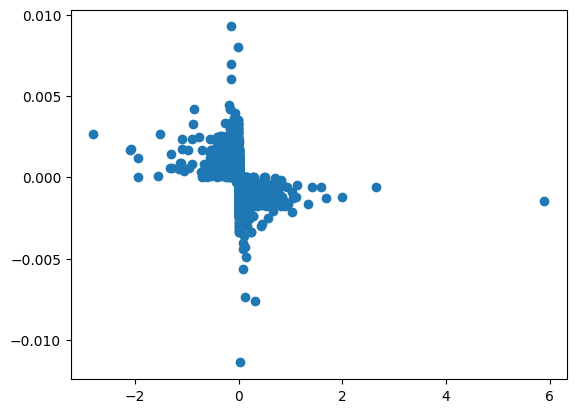

In [31]:
plt.scatter(logRetDtDailyTransform(Signal),
            logRetDtDailyTransform(pd.DataFrame(hf_df[reference_ticker])))

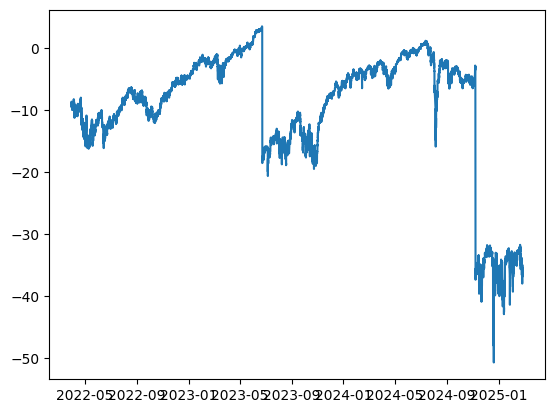

In [32]:
plt.plot(Signal)

Text(0, 0.5, 'Value')

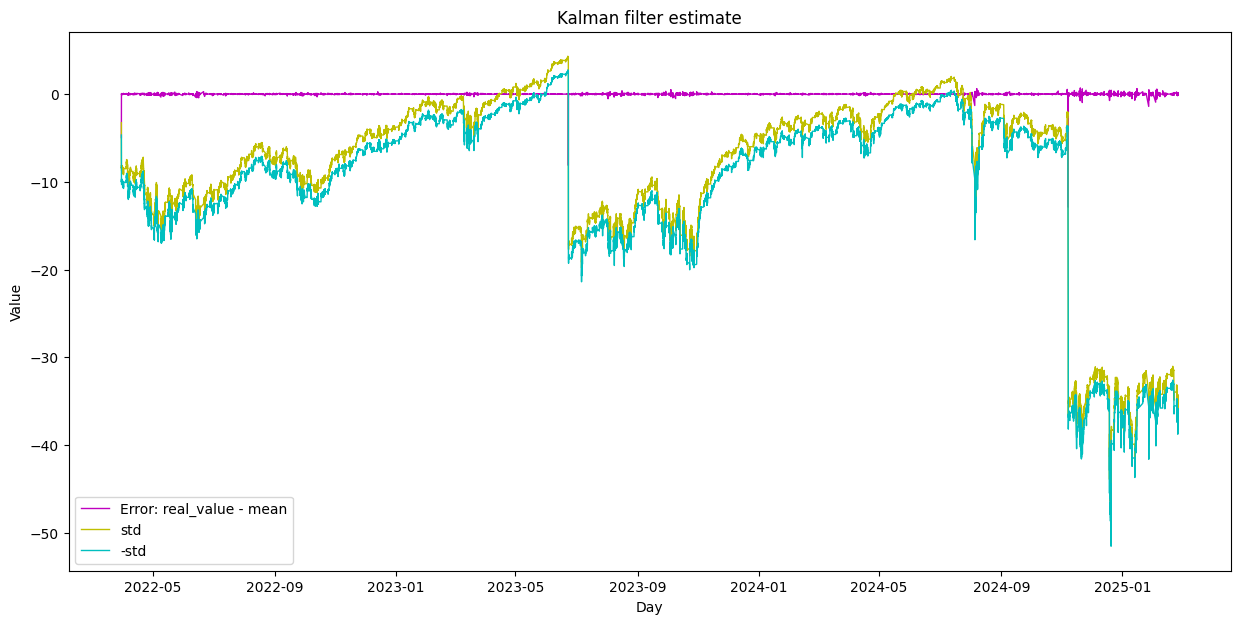

In [33]:
## Filtering
# filter = KalmanFilter(raw)
reload(KalmanFilter)
names = [0, 'VIXY']#['AIQ',0]
means, covs = KalmanFilter.KalmanFilter.UnivariateKF('Signal', Signal, 
                                                     1,
                                                     1)
# Create subplots with shared axes
# fig, axes = plt.subplots(1, 2, sharex=True)
# # Plot data on each subplot
# axes[0].plot(Signal.index, means.squeeze())
# axes[1].plot(Signal.index, covs.squeeze())

mean, std = means.squeeze(), np.std(covs.squeeze())

plt.figure(figsize=(15,7))
plt.plot(Signal.index, Signal['Signal'] - mean, 'm', lw=1)
plt.plot(Signal.index, mean.squeeze() + np.sqrt(covs.squeeze()), 'y', lw=1)
plt.plot(Signal.index, mean.squeeze() - np.sqrt(covs.squeeze()), 'c', lw=1)
plt.title('Kalman filter estimate')
plt.legend(['Error: real_value - mean', 'std', '-std'])
plt.xlabel('Day')
plt.ylabel('Value')

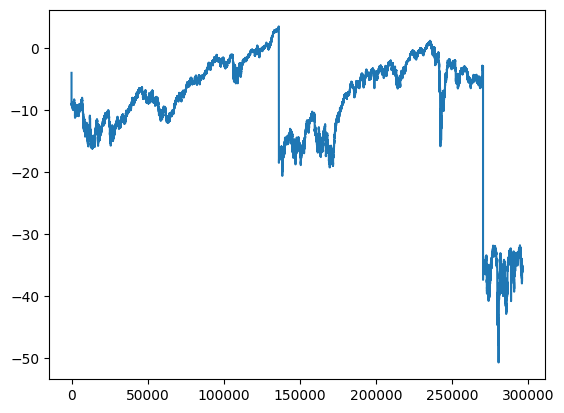

In [34]:
"""
Need to check math on regression on return back to signal level.
logret(Y) = Beta*logret(X) [assume  centered 0]
log(Y) - log(Y') = Beta*(log(X) - log(X'))
log(Y) - log(Y') = log(sum_i x_i^beta_i) - log(sum_i x'_i^beta_i)

"""
state_means, state_covs =means, covs 
plt.plot(state_means)#, state_covs
# DataExtensions.draw_slope_intercept_changes(Signal, state_means)

[ -3.95805033  -6.92166904  -8.13757415 ... -35.63168415 -35.63114948
 -35.62665098]


Text(0, 0.5, 'Residuals')

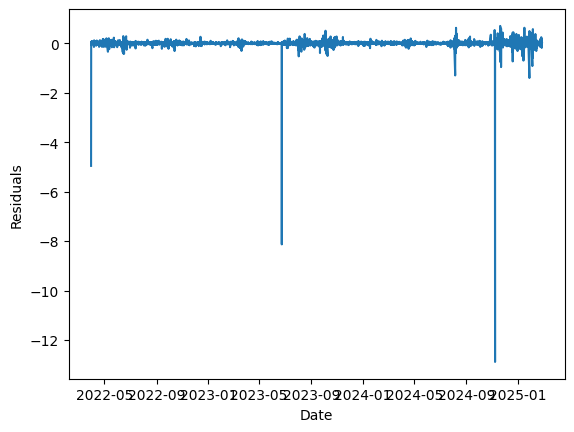

In [35]:
state_means0 = np.array(pd.DataFrame(state_means)[0])
print(state_means0)
resid = Signal['Signal'] - state_means0
stdev = []
for i in range(len(resid)):
    stdev.append(math.sqrt(state_covs[i][0][0]))
plt.plot(resid)
plt.xlabel('Date')
plt.ylabel("Residuals")

# adf_test(resid.dropna())

# H, c,  drop = compute_Hc(resid.dropna())
# print('Hurst Exponent', H)

## Portfolio Optimization

In [36]:
means

array([[ -3.95805033],
       [ -6.92166904],
       [ -8.13757415],
       ...,
       [-35.63168415],
       [-35.63114948],
       [-35.62665098]])

In [37]:
bounds = {'Mu':0, 'Sigma':0, 'Beta':0, 'Mu_Min':0, 'Sigma_Min':0}
MIP = OptimizationEngine.mipEngine.mipEngine()
# MIP._addVariables(mf_summary.columns, var_bounds=(None,None), var_type="INTEGER")
MIP._addConstraints(mf_summary, bounds, var_bounds=(1,None))
MIP._optimize()
#pd.DataFrame(mf_summary)

optimal solution cost 0.0 found
solution:


In [38]:
raw = raw.reset_index().set_index('timestamp')
raw

,0,VIXY
timestamp,,
2022-03-30 13:32:00,6.850899,15.7670
2022-03-30 13:33:00,6.852585,15.7500
2022-03-30 13:34:00,6.852585,15.7501
2022-03-30 13:35:00,6.853302,15.7200
2022-03-30 13:36:00,6.854373,15.7500
...,...,...
2025-02-25 23:55:00,8.188313,43.8200
2025-02-26 00:01:00,8.188313,43.8200
2025-02-26 00:17:00,8.189093,43.8200


In [39]:
from statsmodels.tsa.vector_ar.vecm import coint_johansen
## analysis between adr spread and volume pct
df = signal

df.fillna(method='ffill', inplace=True)
# df['ADR_Vol_Pct'] = df['TSMC34_SA_Volume']/(df['TSMC34_SA_Volume'] +df['TSM_Volume'])
mean = df.mean()
std = df.std()
# df['ADR_Vol_Pct'] = (df['ADR_Vol_Pct'] - mean)/std
# df['ADR_Spread'] = df['TSM_Close'] - df['TSMC34_SA_Close']
# mean = df['ADR_Spread'].mean()
# std = df['ADR_Spread'].std()
# df['ADR_Spread'] = (df['ADR_Spread'] - mean)/std
coint_test_result = coint_johansen(raw, det_order=1, k_ar_diff=0)
tracevalues = coint_test_result.lr1
critical_values = coint_test_result.cvt
for i, (stock1, stock2) in enumerate([list(raw.columns.values)]):
    if (tracevalues[i] > critical_values[:, 1]).all():
        print(f"Pair {i + 1} ({stock1} and {stock2}) is cointegrated.")
    else:
        print(f"Pair {i + 1} ({stock1} and {stock2}) is not cointegrated.")

Pair 1 (0 and VIXY) is not cointegrated.


C:\Users\raymo\AppData\Local\Temp\ipykernel_47712\246132147.py:5: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)


In [40]:
np.std(np.array(covs).flatten())/np.array(means).flatten()
# init_mu

array([-5.54469772e-05, -3.17065039e-05, -2.69689618e-05, ...,
       -6.15917916e-06, -6.15927159e-06, -6.16004931e-06])

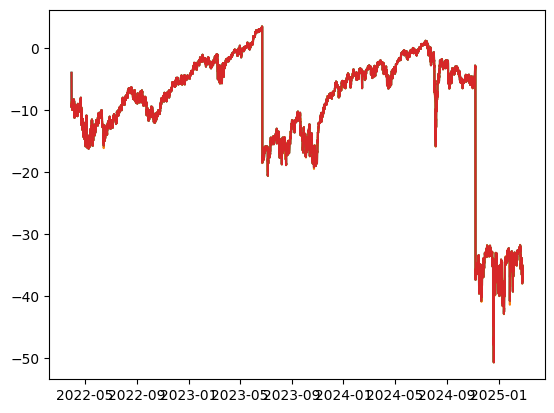

In [43]:
### roll filter over 90 day windows
roll = 0
training_period = datetime.timedelta(days=90)
# testing_period = datetime.timedelta(days=30)
min_time_delta = datetime.timedelta(hours=1)
start_date = Signal.index[0] 
means = []
covs = []
init_mu = 1#np.mean(Signal[start_date:start_date+training_period])
init_cov = 1#np.var(Signal[start_date:start_date+training_period])
start_date += (training_period + min_time_delta)
# while (start_date + training_period < Signal.index[-1]):
#     means_temp, covs_temp = KalmanFilter.KalmanFilter.UnivariateKF('Signal', 
#                 Signal[start_date:start_date+training_period], 
#                 init_mu,
#                 init_cov
#                 )
#     means.extend(means_temp)
#     covs.extend(covs_temp)
#     init_mu = 1#np.mean(Signal[start_date:start_date+training_period])
#     init_cov = 1#np.var(Signal[start_date:start_date+training_period])
#     # print(len(Signal[start_date:start_date+training_period]),len(covs))
#     # print()
#     start_date += (training_period + min_time_delta)
# means_temp, covs_temp = KalmanFilter.KalmanFilter.UnivariateKF('Signal', 
#             Signal[start_date:], 
#             init_mu,
#             init_cov)
# means.extend(means_temp)
# covs.extend(covs_temp)

means, covs = KalmanFilter.KalmanFilter.UnivariateKF('Signal', 
            Signal, 
            init_mu,
            init_cov
            )
# print(len(Signal[start_date:]), len(covs))
plt.plot(Signal.index, np.array(means).flatten())
plt.plot(Signal)
plt.plot(Signal.index, np.array(means).flatten() + np.std(np.array(covs).flatten()))
plt.plot(Signal.index, np.array(means).flatten() - np.std(np.array(covs).flatten()))

In [44]:
means

array([[ -3.95805033],
       [ -6.92166904],
       [ -8.13757415],
       ...,
       [-35.63168415],
       [-35.63114948],
       [-35.62665098]])

[[ -3.95805033]
 [ -6.92166904]
 [ -8.13757415]
 ...
 [-35.63168415]
 [-35.63114948]
 [-35.62665098]]


Text(0, 0.5, 'Residuals')

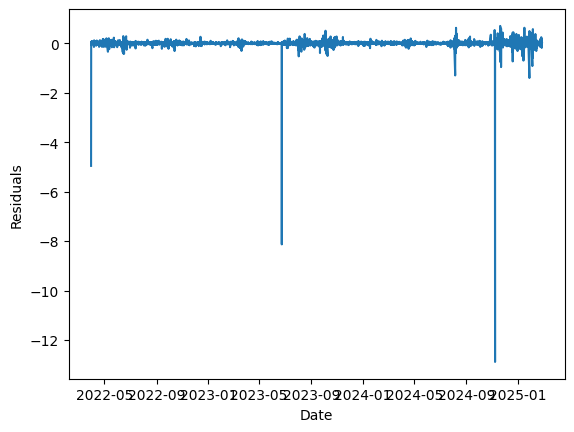

In [45]:
state_means0 = np.array(pd.DataFrame(means.flatten()))
print(means)
resid = Signal['Signal'] - means.flatten()
stdev = []
# for i in range(len(resid)):
#     stdev.append(math.sqrt(covs[0].flatten()[i]))
stdev = covs.flatten()
plt.plot(resid)
plt.xlabel('Date')
plt.ylabel("Residuals")

# adf_test(resid.dropna())

# H, c,  drop = compute_Hc(resid.dropna())
# print('Hurst Exponent', H)

Text(0, 0.5, 'Value')

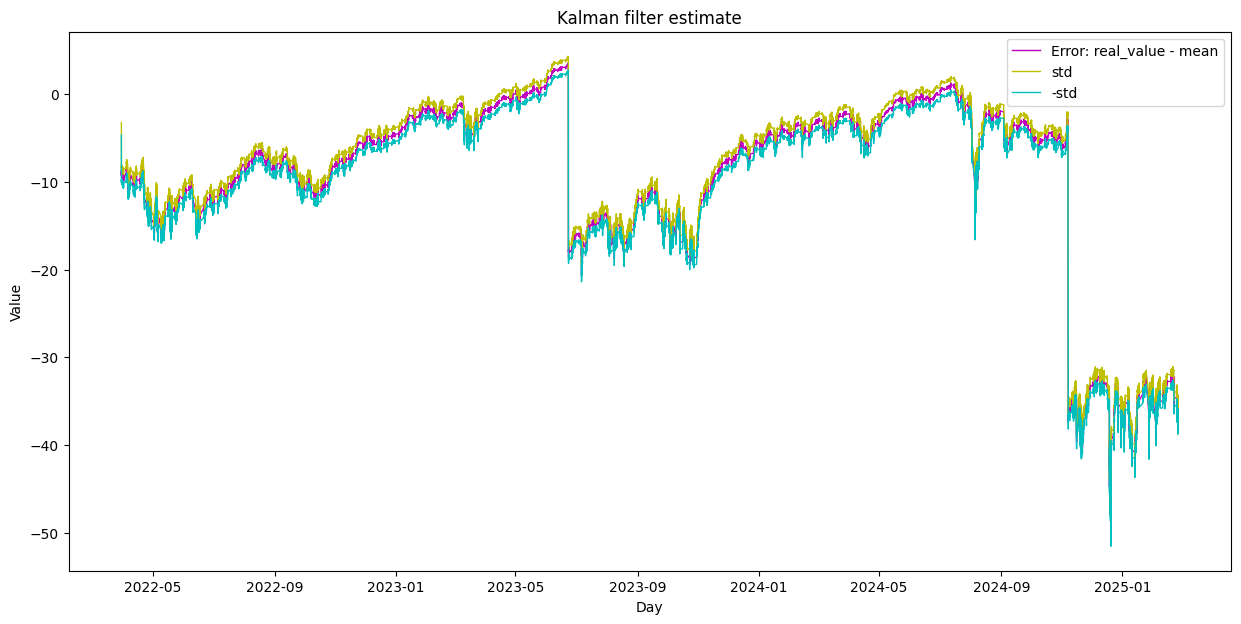

In [53]:
# mean, std = means.squeeze(), np.std(covs.squeeze())

plt.figure(figsize=(15,7))
plt.plot(Signal.index, Signal['Signal'], 'm', lw=1)
plt.plot(Signal.index, np.array(means).squeeze() + np.sqrt(covs.flatten()), 'y', lw=1)
plt.plot(Signal.index, np.array(means).squeeze() - np.sqrt(covs.flatten()), 'c', lw=1)
plt.title('Kalman filter estimate')
plt.legend(['Error: real_value - mean', 'std', '-std'])
plt.xlabel('Day')
plt.ylabel('Value')

In [65]:
from statsmodels.regression.rolling import RollingOLS

df = pd.DataFrame()
df['primitive_signal'] = Signal['Signal']
df = df.merge(hf_df, on='timestamp', how='left')
df['filter_resid'] = resid
df['filter_spread'] = stdev

def simpleFilterSignal(dr, epsilon):
    if dr.filter_resid < -dr.filter_spread*epsilon:
        return -1
    elif dr.filter_resid > dr.filter_spread*epsilon:
        return 1
    else:
        return 0

# means, covs = KalmanFilter.KalmanFilter.UnivariateKF('Signal', Signal, 
#                                                      np.mean(Signal[-252:]),
#                                                      np.var(Signal[-252:]))

df['Signal'] = df.apply(lambda dr: simpleFilterSignal(dr, 1.5), axis=1)
df['BuySell'] = (df['Signal'] - df['Signal'].shift(1))/2
df = df.reset_index().rename(columns={"timestamp":"Date"})
### rolling coefficient
window = 60*9.5*21 #21 days
LEGS = list(mf_bucket.keys())
ret_df = logRetDtDailyTransform(df[LEGS])
# df['HedgeRatio'] = ret_
model = RollingOLS(-1*ret_df[reference_ticker], ret_df[[x for x in LEGS if x != reference_ticker]], window=window)
hedge_ratios = model.fit().params.shift(1)
for ticker in LEGS:
    if ticker == reference_ticker:
        df[f'{ticker}_hr'] = -1
    else:
        df[f'{ticker}_hr'] = hedge_ratios[ticker]
df

,Date,primitive_signal,SVXY,SVIX,VIXY,filter_resid,filter_spread,Signal,BuySell,SVXY_hr,SVIX_hr,VIXY_hr
0,2022-03-30 13:32:00,-8.916101,56.14,14.8800,15.7670,-4.958050,0.500000,-1,NaN,NaN,NaN,-1
1,2022-03-30 13:33:00,-8.897415,56.15,14.8900,15.7500,-1.975746,0.600000,-1,0.0,NaN,NaN,-1
2,2022-03-30 13:34:00,-8.897515,56.15,14.8900,15.7501,-0.759941,0.615385,0,0.5,NaN,NaN,-1
3,2022-03-30 13:35:00,-8.866698,56.22,14.8900,15.7200,-0.278783,0.617647,0,0.0,NaN,NaN,-1
4,2022-03-30 13:36:00,-8.895627,56.17,14.9000,15.7500,-0.117553,0.617978,0,0.0,NaN,NaN,-1
...,...,...,...,...,...,...,...,...,...,...,...,...
296160,2025-02-25 23:55:00,-35.631687,50.30,24.9000,43.8200,0.003285,0.618034,0,0.0,1.009205,0.284180,-1
296161,2025-02-26 00:01:00,-35.631687,50.30,24.9000,43.8200,0.001255,0.618034,0,0.0,1.009177,0.284185,-1
296162,2025-02-26 00:17:00,-35.630907,50.37,24.9000,43.8200,0.000778,0.618034,0,0.0,1.009080,0.284186,-1
296163,2025-02-26 00:22:00,-35.630819,50.37,24.9007,43.8200,0.000330,0.618034,0,0.0,1.008899,0.284207,-1


In [61]:
BBO = order_book.Book()
HOLDING_PERIOD_CHECK = {}
isLong = False
hasPosition = False

def isFirstTrade(ticker, date):
    if ticker not in HOLDING_PERIOD_CHECK:
        return True
    if date not in HOLDING_PERIOD_CHECK[ticker]:
        return True
    return False

pairsLEGS = [x for x in LEGS if x != reference_ticker]

for _, row in df.iloc[window:].iterrows():
    if (row.BuySell == 1 
        and not hasPosition
        and isFirstTrade(reference_ticker, row.Date.normalize())):
        print('bought spread at ', row.Date)
        BBO.addOrder(row.Date, reference_ticker, row[reference_ticker],10 * row[f'{reference_ticker}_hr'])
        for LEG in pairsLEGS:
            BBO.addOrder(row.Date, LEG, row[LEG], -10 * row[f'{LEG}_hr'])
        if reference_ticker not in HOLDING_PERIOD_CHECK:
            HOLDING_PERIOD_CHECK[reference_ticker] = []
        HOLDING_PERIOD_CHECK[reference_ticker].append(row.Date.normalize())
        isLong = True
        hasPosition = True
    elif (row.BuySell == -1 
        and not hasPosition
        and isFirstTrade(reference_ticker, row.Date.normalize())):
        print('sold spread at ', row.Date)
        BBO.addOrder(row.Date, reference_ticker, row[reference_ticker], -10 * row[f'{reference_ticker}_hr'])
        for LEG in pairsLEGS:
            BBO.addOrder(row.Date, LEG, row[LEG], 10 * row[f'{LEG}_hr'])
        isLong = False
        if reference_ticker not in HOLDING_PERIOD_CHECK:
            HOLDING_PERIOD_CHECK[reference_ticker] = []
        HOLDING_PERIOD_CHECK[reference_ticker].append(row.Date.normalize())
        hasPosition = True
        isLong = False
    else:
        if hasPosition and isFirstTrade(reference_ticker, row.Date.normalize()):
            print('exit spread at ', row.Date)
            prices = {}
            for ticker in LEGS:
                prices[ticker] = row[ticker]
            BBO.unwindALL(row.Date, prices =prices)
            if reference_ticker not in HOLDING_PERIOD_CHECK:
                HOLDING_PERIOD_CHECK[reference_ticker] = []
                HOLDING_PERIOD_CHECK[reference_ticker].append(row.Date.normalize())
            hasPosition = False
            isLong = False

#BBO.addOrder(df_res.iloc[100]["Date"], "TSM", 300.0, 10)
#BBO.addOrder(df_res.iloc[120]["Date"], "TSM", 250.0, 25)
#BBO.addOrder(df_res.iloc[200]["Date"], "TSM", 350.0, -30)
#BBO.getTickerBook(["TSLA"]).tail(1)#.loc['Quantity']
#BBO.get_history()

#BBO.addOrder(df_res.iloc[50]["Date"], "TSMC34.SA", 300.0, 10)
#BBO.addOrder(df_res.iloc[150]["Date"], "TSMC34.SA", 250.0, -25)

In [66]:
BBO.get_history()

[]

In [62]:
BBO.getOrderDf()

""


In [58]:

df_res = pd.DataFrame()

for ticker in LEGS:
    df_temp = df[['Date',ticker]].rename(columns={ticker:"Price"})
    df_temp['Ticker'] = ticker
    df_res = pd.concat([df_res, df_temp])

#1.rename(columns={'SVIX':'Price'}),df2.rename(columns={'VIXY':'Price'})])
df_res
#df1.drop('index', inplace=True)
#df_res.rename(columns={'Datetime':'Date'}, inplace=True)
BBO.backfillPnL(df_res)

,Date,Price,Ticker
0,2022-03-30 13:32:00,56.14,SVXY
1,2022-03-30 13:33:00,56.15,SVXY
2,2022-03-30 13:34:00,56.15,SVXY
3,2022-03-30 13:35:00,56.22,SVXY
4,2022-03-30 13:36:00,56.17,SVXY
...,...,...,...
296160,2025-02-25 23:55:00,43.82,VIXY
296161,2025-02-26 00:01:00,43.82,VIXY
296162,2025-02-26 00:17:00,43.82,VIXY
296163,2025-02-26 00:22:00,43.82,VIXY


In [59]:
hist

""


KeyError: 'Value'

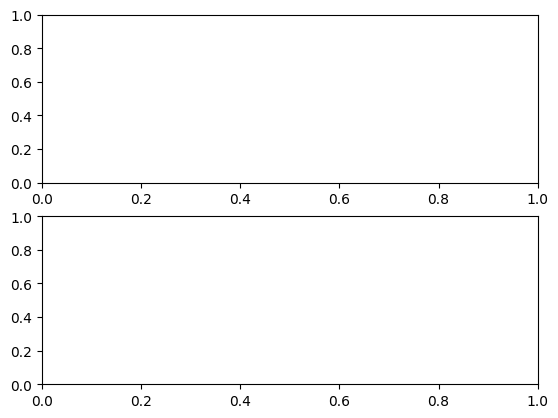

In [60]:
hist = BBO.getHistoryDf()
figure, axis = plt.subplots(2,1)

# For Sine Function
axis[0].plot(hist.index, hist['Value'] + hist['Cash'])
# axis[0, 0].set_title("Sine Function")

# For Cosine Function
axis[1].plot(Signal.index, Signal)
# axis[0, 1].set_title("Cosine Function")
# plt.plot(hist['PnL'])
plt.show()

In [ ]:
### Sharpe Ratio and whatnot


### drawdown


In [109]:
BBO.getHistoryDf()

,CostBasis,Value,PnL,Cash
Date,,,,
2022-03-30 04:00:00,0.0,0.0,0.000000,0.000000
2022-03-31 04:00:00,0.0,0.0,0.000000,0.000000
2022-04-01 04:00:00,0.0,0.0,0.000000,0.000000
2022-04-04 04:00:00,0.0,0.0,0.000000,0.000000
2022-04-05 04:00:00,0.0,0.0,0.000000,0.000000
...,...,...,...,...
2025-02-13 05:00:00,0.0,0.0,-433.223926,-433.223926
2025-02-14 05:00:00,0.0,0.0,-433.223926,-433.223926
2025-02-18 05:00:00,0.0,0.0,-433.223926,-433.223926
